In [27]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='010173f3-b241-4bfd-85c1-e5977ee3e9ca', project_access_token='p-4b06a48c2cbde5d2d1b8ecfd82c7b0d3cd55a6f9')
pc = project.project_context


# MARATÓN BEHIND THE CODE 2020

## DESAFÍO 8 - Digital House

El reto de Digital House tiene que ver con la misión y visión de la empresa; la cual busca transformar la vida de las personas, desarrollando competencias digitales, para que generen un impacto positivo en la sociedad. En ese sentido, Digital House busca a través de este desafío medir la empleabilidad de los cursos que disponibiliza en su plataforma, es decir que tan factible es que un alumno o egresado de Digital House acceda al mercado laboral o consiga un trabajo en su área luego de finalizar uno o varios de los cursos ofrecidos en la plataforma.

Entender que características o variables hacen que una persona sea más o menos empleable es fundamental para la empresa y para generar ese impacto positivo que busca aportar a la sociedad

<hr>



### Instalación de algunas bibliotecas de Python

In [28]:
!pip install scikit-learn --upgrade
!pip install scipy --upgrade
!pip install fancyimpute --upgrade
!pip install category_encoders
!pip install xgboost

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.5.2)
Requirement already up-to-date: fancyimpute in /usr/local/lib/python3.6/dist-packages (0.5.5)


<hr>

### Descargue el conjunto de datos del desafío en formato .csv

In [29]:
import pandas as pd

!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
df_training_dataset = pd.read_csv(r'train_dataset_digitalhouse.csv')
df_training_dataset.tail()

--2020-09-17 13:10:29--  https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 654532 (639K) [text/plain]
Saving to: ‘train_dataset_digitalhouse.csv.1’

train_dataset_digit 100%[===================>] 639.19K  --.-KB/s    in 0.07s   

2020-09-17 13:10:30 (8.33 MB/s) - ‘train_dataset_digitalhouse.csv.1’ saved [654532/654532]



,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
8990,9995,29.0,MASCULINO,ARGENTINA,TERTIARY,DEVELOPMENT,NaN,4.0,4701.6,9.1,86.0
8991,9996,34.0,NaN,ARGENTINA,UNIVERSITARY,ENGINEERING,PROGRAMACION,3.4,4646.2,16.8,95.0
8992,9997,28.0,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,NaN,3315.1,5.6,95.0
8993,9998,23.0,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,3.3,4437.8,0.9,87.0
8994,9999,36.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,3.4,4600.8,19.6,88.0


### Explorando los datos proporcionados


* Unnamed: 0
* EDAD
* GENERO
* RESIDENCIA
* NV_ESTUDIO
* ESTUDIO_PREV
* TRACK_DH
* AVG_DH
* MINUTES_DH
* EXPERIENCIA
* **DIAS_EMP = El valor "target" que se va a predecir**

Podemos verificar fácilmente que faltan valores usando el siguiente código:

```df_training_dataset.info()```

Debe manejar cuidadosamente estos valores faltantes antes de crear un modelo de regresión.

In [30]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8995 entries, 0 to 8994
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    8995 non-null   int64  
 1   EDAD          7668 non-null   float64
 2   GENERO        7620 non-null   object 
 3   RESIDENCIA    7638 non-null   object 
 4   NV_ESTUDIO    7623 non-null   object 
 5   ESTUDIO_PREV  7665 non-null   object 
 6   TRACK_DH      7714 non-null   object 
 7   AVG_DH        7651 non-null   float64
 8   MINUTES_DH    7619 non-null   float64
 9   EXPERIENCIA   7618 non-null   float64
 10  DIAS_EMP      8995 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 773.1+ KB


#### Verificar tipos de features(Categoricas, Ordinal, Numerica)

In [31]:
df_training_dataset.nunique()

Unnamed: 0      8995
EDAD              37
GENERO             2
RESIDENCIA         3
NV_ESTUDIO         3
ESTUDIO_PREV       5
TRACK_DH           4
AVG_DH            29
MINUTES_DH      5109
EXPERIENCIA      318
DIAS_EMP          34
dtype: int64

#### Relacion entre Features

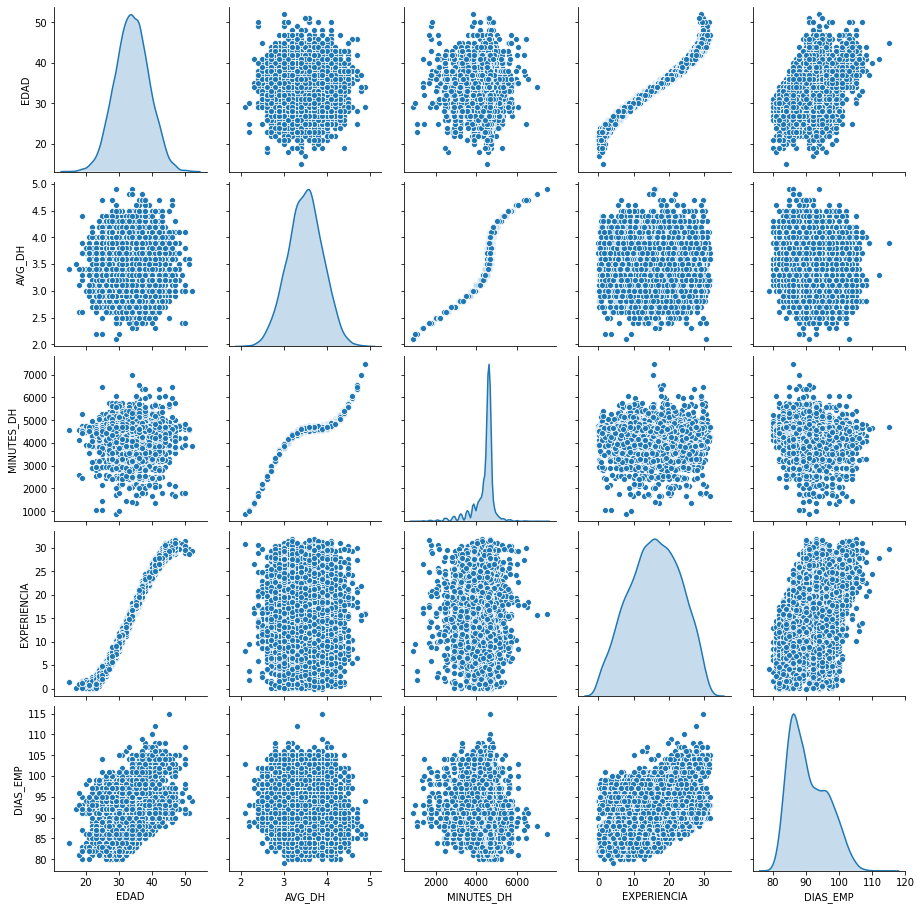

In [32]:
import seaborn as sns
%matplotlib inline

sns.pairplot(df_training_dataset.drop(columns=['Unnamed: 0']), diag_kind="kde")

Entre 'EXPERIENCIA' y 'EDAD' hay una relacion, lo mismo suceede entre 'MINUTOS_DH' y 'AVG_DH'.
Para Experiencia y edad, de google sheet puede hacer una regresión polinomica con los siugientes valores:


```
#features['EXPERIENCIA'].fillna((55.3 - 6.74*features['EDAD'] + 0.249*features['EDAD']**2 + (-2.48E-03)*features['EDAD']**3), inplace=True)
#features['EDAD'].fillna((17.9 + 2.11*features['EXPERIENCIA'] + -0.108*features['EXPERIENCIA']**2 + 2.37E-03*features['EXPERIENCIA']**3), inplace=True)
```



Pero no mejoro en nada el modelo, el IterativeImputer fué mas eficiente.

#### Relacion Target vs Features

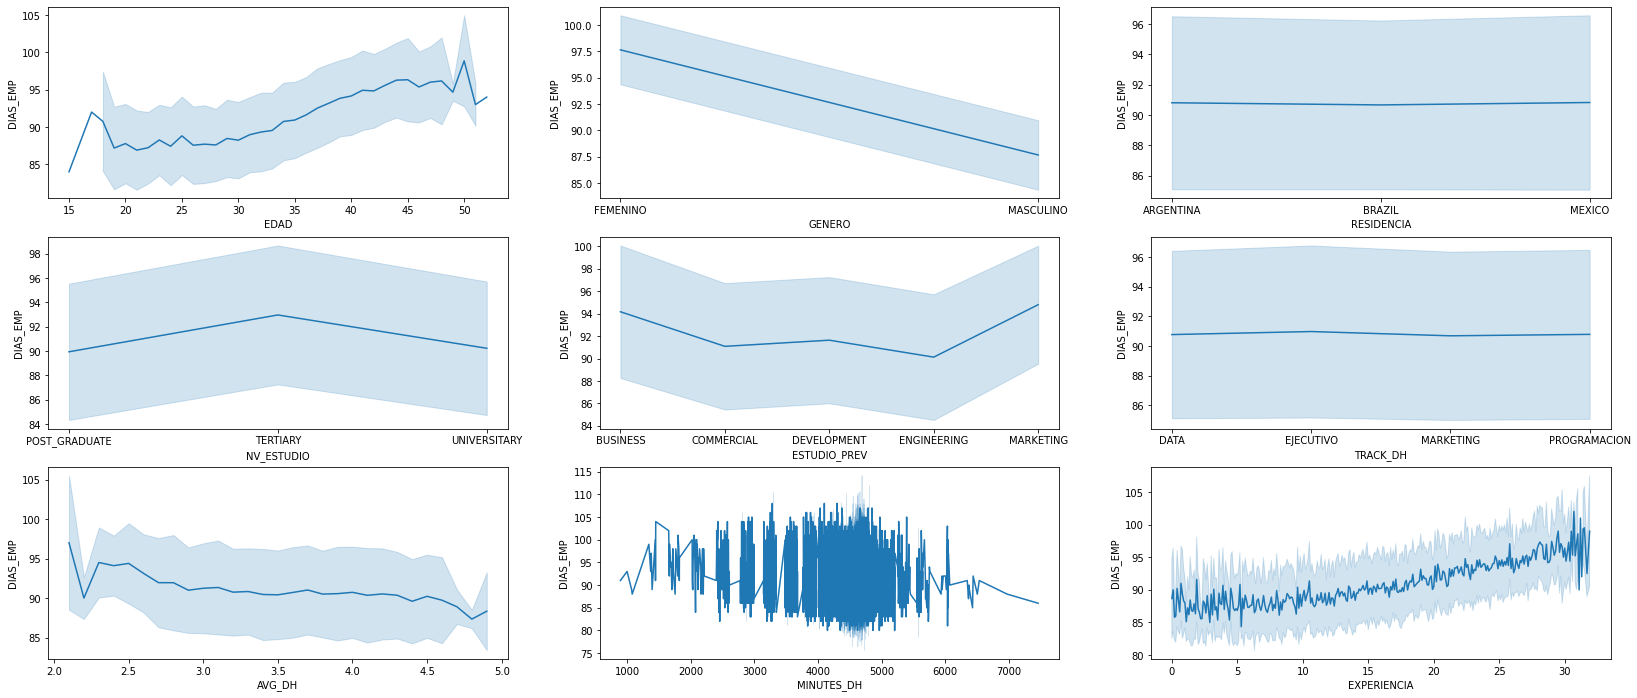

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(28, 12))

sns.lineplot(x="EDAD", y="DIAS_EMP",err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][0])
sns.lineplot(x="GENERO", y="DIAS_EMP", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][1])
sns.lineplot(x="RESIDENCIA", y="DIAS_EMP", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][2])

sns.lineplot(x="NV_ESTUDIO", y="DIAS_EMP",err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[1][0])
sns.lineplot(x="ESTUDIO_PREV", y="DIAS_EMP", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[1][1])
sns.lineplot(x="TRACK_DH", y="DIAS_EMP", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[1][2])

sns.lineplot(x="AVG_DH", y="DIAS_EMP",err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[2][0])
sns.lineplot(x="MINUTES_DH", y="DIAS_EMP", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[2][1])
sns.lineplot(x="EXPERIENCIA", y="DIAS_EMP", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[2][2])

Las graficas estan relacinadas con el promedio.

Se desprende que el 'GENERO' es un factor muy imporante. Los 'MASCULINO' tienen un tiempo mucho menor.

La edad tambien juega un papel muy importante. 
 - De 20 a 30 parece casi plano
 - De 30 a 45, se ve una recta alcista.

En cuanto al Nivel de estudio, a mayor nivel menor tiempo. Casi no hay diferencia entre 'POST_GRADUATE' y 'UNIVERSITARY'.

Por el lado de la 'RESIDENCIA' es muy parejo, apenas por abajo se cuentra 'BRAZIL', la veo como candidato a eliminar.

Analizando 'ESTUDIO_PREV' la las ramas 'BUSINESS' y 'MARKETING' tienen tiene valores mas altos. La de menor valor es 'ENGINEERING'.

Con el aumento de 'AVG_DH' tiende a disminuir 'DIAS_EMP'.

En 'MINUTES_DH' pareciera ver una tendencia a disminuir el TARGET ante un aumento de esta, tiene un **pendiente similar** a 'AVG_DG' probablemente exista alguna correlación entre estas. Pero es muy ruidosa. Si hay correlacion con 'AVG_DH' creeria que es mejor elminiar 'MINUTES_DH' en favor de 'AVG_DH'

'EXPERIENCIA' tiene un comportamiento **simil** a 'EDAD' se deberia analizar bien correlación entre estas.

'TRACK_DH' Es otro candidato a eliminar.



##### Analisis de Genero

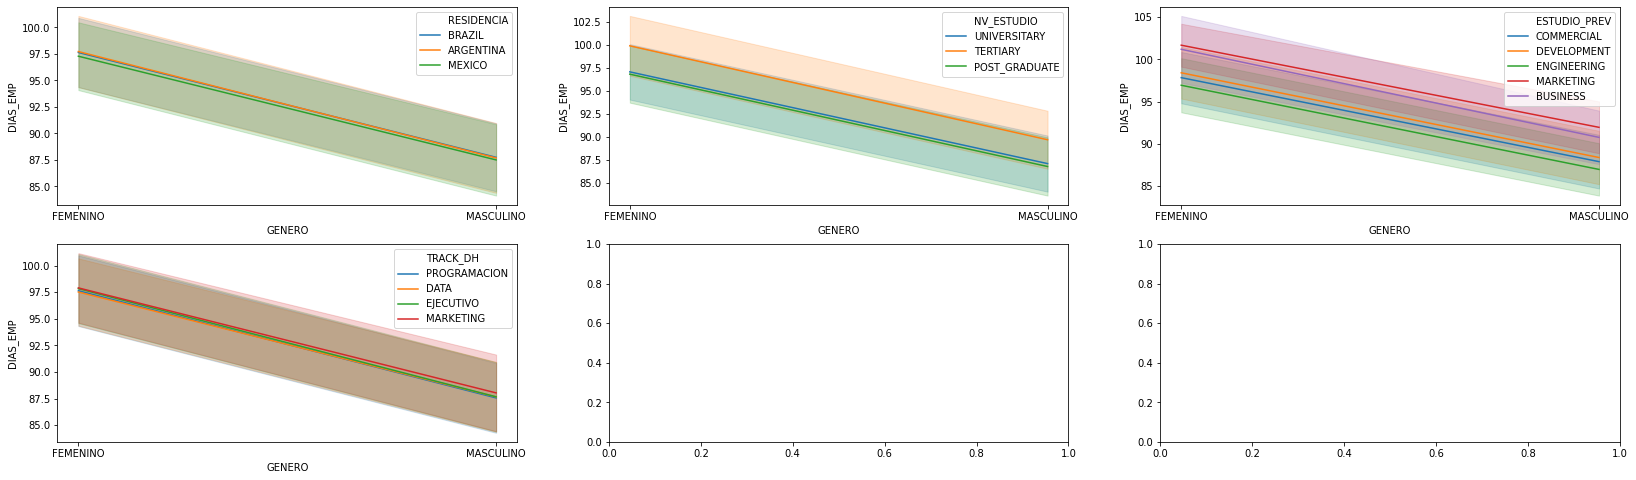

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(28, 8))

sns.lineplot(x="GENERO", y="DIAS_EMP", hue="RESIDENCIA", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][0])
sns.lineplot(x="GENERO", y="DIAS_EMP", hue="NV_ESTUDIO", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][1])
sns.lineplot(x="GENERO", y="DIAS_EMP", hue="ESTUDIO_PREV", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][2])

sns.lineplot(x="GENERO", y="DIAS_EMP", hue="TRACK_DH", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[1][0])

In [35]:
genero = df_training_dataset.groupby('GENERO')
genero.count()/len(df_training_dataset['GENERO'])*100

,Unnamed: 0,EDAD,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
GENERO,,,,,,,,,,
FEMENINO,26.570317,22.779322,22.312396,22.579211,22.934964,22.912729,22.601445,22.312396,22.101167,26.570317
MASCULINO,58.143413,49.416342,49.772096,49.182879,49.294052,49.783213,49.571984,49.282935,49.716509,58.143413


In [36]:
genero.describe()

Unnamed: 0                            ... DIAS_EMP              
               count         mean          std  ...      50%    75%    max
GENERO                                          ...                       
FEMENINO      2390.0  5467.273222  2602.979897  ...     97.0  100.0  115.0
MASCULINO     5230.0  5518.562715  2603.370399  ...     87.0   90.0  103.0

[2 rows x 48 columns]

No puedo inferir nada que me haga suponer o estimar cual es el genero en los datos faltantes de la columna 'GENERO', a xepcion de 'DIAS_EMP' pero mi target. En Google Sheet se me hizo más facil ocn tablas dinamicas.

El unico dato que me hizo ruido es 'MINUTES_DH' los valores max  y min, según genero. Hya bastante dif, hay que analizar si no son outliers

##### Analisis de NV_ESTUDIO

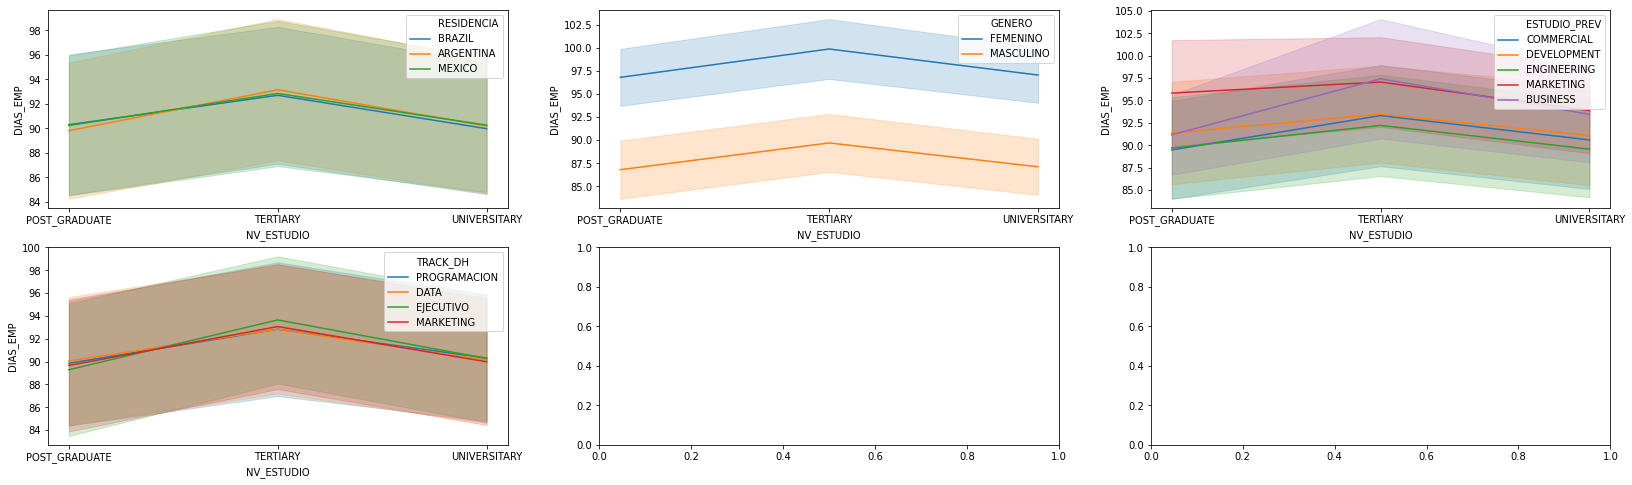

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(28, 8))

sns.lineplot(x="NV_ESTUDIO", y="DIAS_EMP", hue="RESIDENCIA", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][0])
sns.lineplot(x="NV_ESTUDIO", y="DIAS_EMP", hue="GENERO", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][1])
sns.lineplot(x="NV_ESTUDIO", y="DIAS_EMP", hue="ESTUDIO_PREV", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[0][2])

sns.lineplot(x="NV_ESTUDIO", y="DIAS_EMP", hue="TRACK_DH", err_style="band", 
             ci='sd', estimator="mean", data=df_training_dataset, ax=axes[1][0])

Las tentencias vistas anteriormente de forma general, se mantienen aun desglozando por genero.

Las tentencias vistas anteriormente de forma general, se mantienen aun desglozando por genero.

In [38]:
nv_studio = df_training_dataset.groupby('NV_ESTUDIO')
nv_studio.describe()

Unnamed: 0                            ... DIAS_EMP             
                   count         mean          std  ...      50%   75%    max
NV_ESTUDIO                                          ...                      
POST_GRADUATE      980.0  5463.048980  2654.190493  ...     89.0  94.0  104.0
TERTIARY          1762.0  5430.013053  2524.667399  ...     92.0  98.0  115.0
UNIVERSITARY      4881.0  5536.677115  2609.956807  ...     89.0  95.0  107.0

[3 rows x 48 columns]

#### Correlacion 

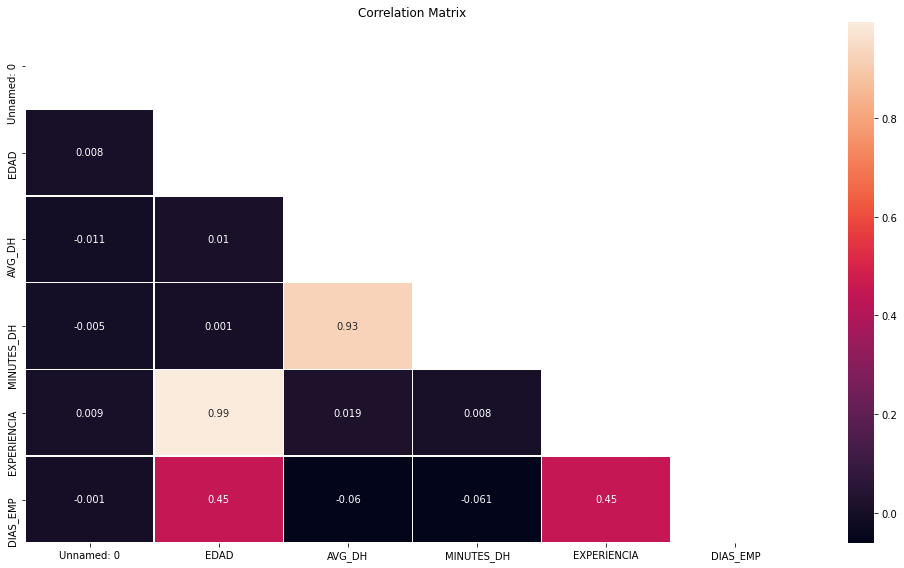

In [39]:
# HeatMap
import numpy as np

plt.figure(figsize = (14, 8))
mask = np.triu(np.ones_like(df_training_dataset.corr(), dtype=bool))

sns.heatmap(round(df_training_dataset.corr(method = 'spearman'), 3), mask=mask,annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()



A trávez de matriz de correlación, podes ver lo que inferimos de los gráficos anteriores. Hay una fuerte correlacion entre EDAD y EXPERIENCIA, asi como entre AVG_DH y MINUTES_DH.

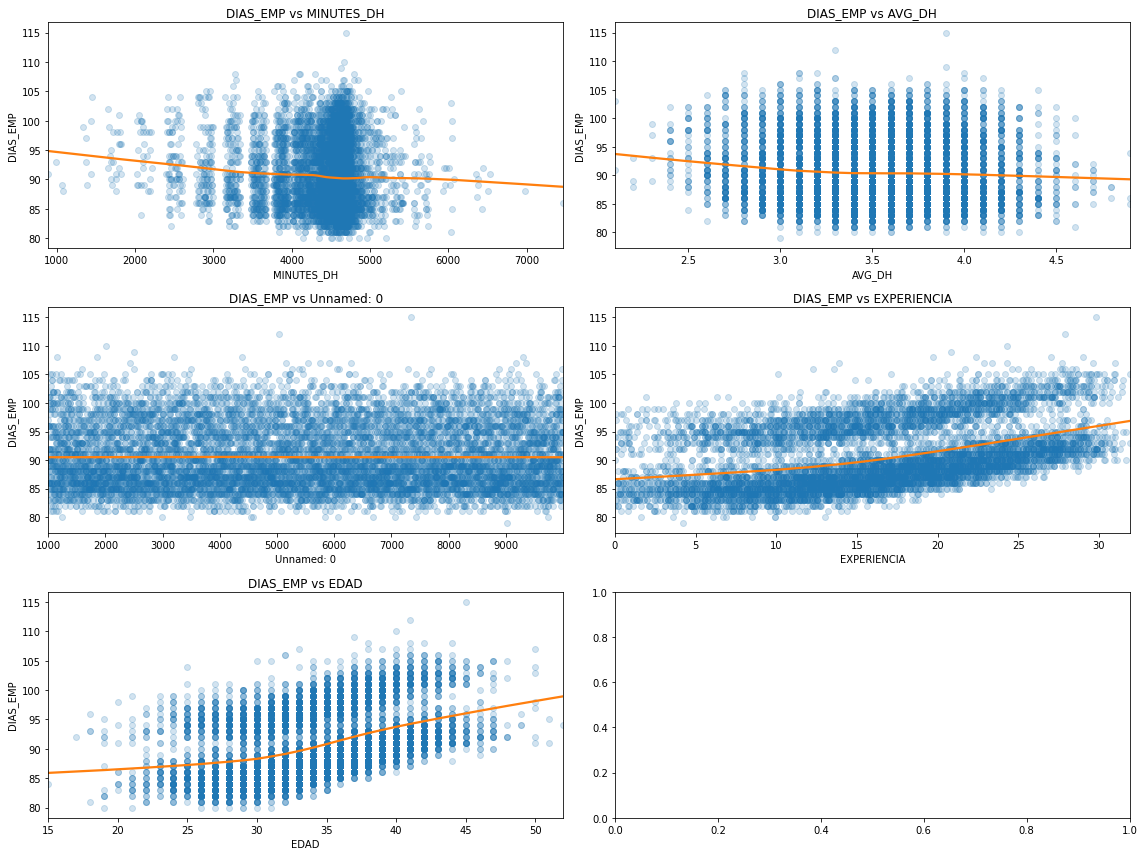

In [40]:
# Scatter plot of DIAS_EMP vs 6 Highest Correlated Columns

topcorr = df_training_dataset.corr(method = 'spearman')['DIAS_EMP'].sort_values()[:-1]
topcorr = topcorr.tail(6)
fig, ax = plt.subplots(3,2, figsize = (16, 12))
ax = ax.ravel()
j = 0
for i in topcorr.index:
    sns.regplot(i, 'DIAS_EMP', ax = ax[j],lowess=True, data = df_training_dataset, color = 'C0', line_kws={"color": "C1"},
               scatter_kws={"alpha": 0.2})
    ax[j].set_title("DIAS_EMP vs {}".format(i))
    j += 1
plt.tight_layout()
plt.show()



#### Distribucion 

<hr>

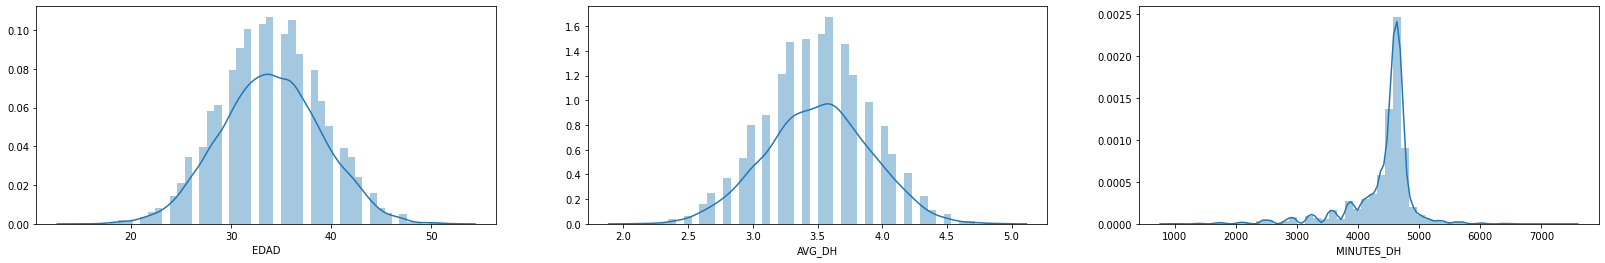

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.distplot(df_training_dataset['EDAD'].dropna(), ax=axes[0])
sns.distplot(df_training_dataset['AVG_DH'].dropna(), ax=axes[1])
sns.distplot(df_training_dataset['MINUTES_DH'].dropna(), ax=axes[2])

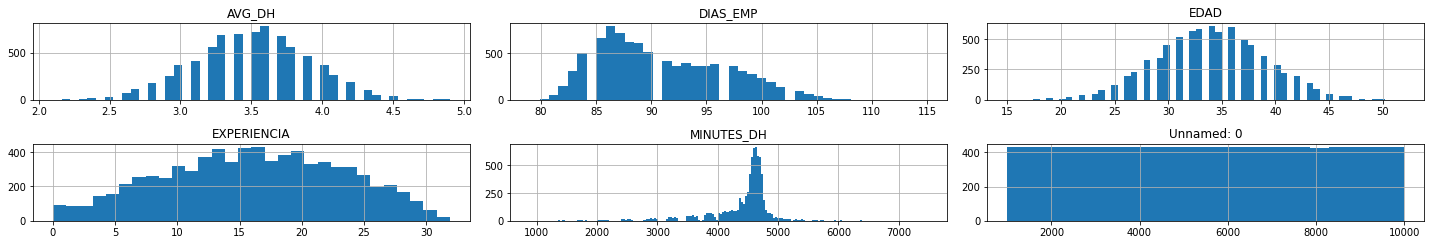

In [42]:
# easy way to plot all numeric columns
df_training_dataset.hist(figsize = (20, 10), layout=(6, 3), bins = 'auto')
plt.tight_layout()
plt.show()

### Probando estrategias Pipeline

#### Defino funciones propias

In [43]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

def evaluate_model(model, X, y, repeats):
  # prepare the cross-validation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=repeats)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
  print('Mean r2: %.3f (%.3f)' % (mean(scores), std(scores)))
  return scores

#### Defino pasos

In [47]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
import category_encoders as ce
import numpy as np

# Trabajando con variables Categoricas como Ordinales.
ordinal_cols_mapping = [
  {'col': 'GENERO',
  'mapping': {
      "FEMENINO": 1,
      np.nan: np.nan,
      'MASCULINO': 0
      }
  },
  {'col': 'NV_ESTUDIO', 
    'mapping': {
        'UNIVERSITARY': 3,
        np.nan: 2,
        'TERTIARY': 4,
        'POST_GRADUATE': 1
        }
    },
  {'col': 'ESTUDIO_PREV',
    'mapping':{ 
        np.nan: 1,
        'COMMERCIAL': 2,
        'DEVELOPMENT': 3,
        'ENGINEERING': 4,
        'MARKETING': 5,
        'BUSINESS': 6
        }
  },
]

encoder = ce.OrdinalEncoder(mapping=ordinal_cols_mapping,handle_unknown="return_nan", handle_missing="return_nan",return_df=True)  

# Trabajando valores NaN 
imp_mean = IterativeImputer(max_iter=500)

# Ajusto Valores
from sklearn.preprocessing import RobustScaler, Normalizer, StandardScaler, PowerTransformer

transformer = StandardScaler()


#### Prueba Removiendo Features con Pipeline

In [94]:

from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, ARDRegression, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import ExtraTreeRegressor
from xgboost import XGBRegressor
# Defino pipeline de pre-procesamiento
my_pipeline = Pipeline([('ordinal', encoder),
                        ('imp_mean', imp_mean),
                        ('scaler', transformer),
                        ('model', XGBRegressor())])

df_test = df_training_dataset.drop(columns=['Unnamed: 0', 'TRACK_DH', 'RESIDENCIA'])
# Separo Features y Target
features = df_test[[column for column in df_test.columns if 'DIAS_EMP' not in column and 'Unnamed: 0' not in column]]
target = df_test['DIAS_EMP']  ## NO CAMBIE EL NOMBRE DE LA VARIABLE "target".

# print("Metricas Sin remover columnas")
evaluate_model(my_pipeline, features, target, 5)

# for c in (features.columns):
#     print("Metricas removiendo: {}".format(c))
#     features_rm = features.drop(c, axis=1, inplace=False)
    
#     evaluate_model(my_pipeline, features_rm, target, 5)

Mean r2: 0.809 (0.011)


array([0.80935761, 0.8190067 , 0.80294104, 0.82375641, 0.78858322,
       0.8106091 , 0.80993456, 0.81332893, 0.81799439, 0.80505066,
       0.82882247, 0.78236389, 0.81701695, 0.81431598, 0.8063003 ,
       0.8141223 , 0.80367138, 0.81098502, 0.81638226, 0.79956354,
       0.80333795, 0.79443623, 0.81858136, 0.81303996, 0.80946286,
       0.81647837, 0.81447621, 0.80005948, 0.81637875, 0.81523685,
       0.79731661, 0.83668804, 0.78998777, 0.80261723, 0.81441928,
       0.81674516, 0.80060386, 0.79565234, 0.82758895, 0.80957514,
       0.79383402, 0.80687002, 0.80839794, 0.80574907, 0.8171114 ,
       0.80405751, 0.79262657, 0.83119906, 0.80938605, 0.81803841])

La clave esta en **'GENERO'**, al eliminar 'GENERO' la performance cae abruptamente. Lo inferimos de las tablas anteriores de relación.
Por lo que habria que buscar alguna forma de estimar si es posible, talvez haciendo alguna suposición, viendo distribuciones en Estudios previos o algo simil.

### Preprocesamiento de datos

#### Removiendo columnas

In [75]:
df_training_dataset_1 = df_training_dataset.drop(columns=['Unnamed: 0', 'TRACK_DH', 'RESIDENCIA'], inplace=False)
df_training_dataset_1.tail()

,EDAD,GENERO,NV_ESTUDIO,ESTUDIO_PREV,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
8990,29.0,MASCULINO,TERTIARY,DEVELOPMENT,4.0,4701.6,9.1,86.0
8991,34.0,NaN,UNIVERSITARY,ENGINEERING,3.4,4646.2,16.8,95.0
8992,28.0,FEMENINO,POST_GRADUATE,ENGINEERING,NaN,3315.1,5.6,95.0
8993,23.0,MASCULINO,TERTIARY,ENGINEERING,3.3,4437.8,0.9,87.0
8994,36.0,MASCULINO,UNIVERSITARY,COMMERCIAL,3.4,4600.8,19.6,88.0


#### Trabajando columnas categoricas/ordinales

In [88]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
import category_encoders as ce
import numpy as np

# Trabajando con variables Categoricas como Ordinales.
ordinal_cols_mapping = [
  {'col': 'GENERO',
  'mapping': {
      "FEMENINO": 1,
      np.nan: np.nan,
      'MASCULINO': 0
      }
  },
  {'col': 'NV_ESTUDIO', 
    'mapping': {
        'UNIVERSITARY': 3,
        np.nan: 2,
        'TERTIARY': 4,
        'POST_GRADUATE': 1
        }
    },
  {'col': 'ESTUDIO_PREV',
    'mapping':{ 
        np.nan: 1,
        'COMMERCIAL': 2,
        'DEVELOPMENT': 3,
        'ENGINEERING': 4,
        'MARKETING': 5,
        'BUSINESS': 6
        }
  },
]

encoder_final = ce.OrdinalEncoder(mapping=ordinal_cols_mapping, handle_unknown="return_nan", handle_missing="return_nan",return_df=True) 

#### Trabajando valores NaN

In [89]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_mean_final = IterativeImputer(max_iter=10)


#### Seleccionando las columnas "features" y "target"

In [90]:
features = df_training_dataset_1[[column for column in df_training_dataset_1.columns if 'DIAS_EMP' not in column]]
target = df_training_dataset_1['DIAS_EMP']  ## NO CAMBIE EL NOMBRE DE LA VARIABLE "target".

#### Standarizo valores

In [91]:
# Ajusto Valores
from sklearn.preprocessing import RobustScaler, Normalizer, StandardScaler, PowerTransformer

transformer_final = StandardScaler()

### Entrenando modelo

#### Generando Modelo
Enrealidad ahora estoy utilizando el pipeline que use en testeos. Mas simple es la mecanica.

In [92]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

# Defino pipeline de pre-procesamiento
my_pipeline_final = Pipeline([('ordinal', encoder_final),
                              ('imp_mean', imp_mean_final),
                              ('scaler', transformer_final),
                              ('model', XGBRegressor(objective="reg:squarederror"))])


#### Evaluando el modelo de regresión con el método  "score()" de sklearn

In [81]:
evaluate_model(my_pipeline_final, features, target, 5)

Mean r2: 0.809 (0.011)


array([0.80880942, 0.81943908, 0.81200196, 0.8005933 , 0.78971471,
       0.79409663, 0.81314129, 0.8086557 , 0.82915322, 0.81120309,
       0.80172099, 0.81087774, 0.79130494, 0.80846906, 0.81982231,
       0.82052284, 0.80685742, 0.79631078, 0.80631324, 0.82287749,
       0.81751333, 0.80506083, 0.8015121 , 0.82837043, 0.82129024,
       0.78528538, 0.80720163, 0.79796519, 0.80076427, 0.82622364,
       0.81521391, 0.8077364 , 0.80797071, 0.81211908, 0.80011708,
       0.80119417, 0.82929573, 0.79254074, 0.80599495, 0.81833417,
       0.80504537, 0.79707954, 0.81438724, 0.80571824, 0.81678769,
       0.830372  , 0.824981  , 0.81001233, 0.79430535, 0.79740337])

#### Entrenamiento Final del modelo con todo el dataset

In [93]:
from sklearn.metrics import r2_score
my_pipeline_final.fit(features, target)
print("R^2 dataset: {}".format(r2_score(target, my_pipeline_final.predict(features))))

R^2 dataset: 0.8230978564788847


<hr>

## Completar los datos necesarios para entregar la solución

### Como entrega de su solución, esperamos los resultados numéricos predichos por su modelo. Como entrada utilizará el archivo "to_be_scored.csv"

In [95]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/to_be_scored_digitalhouse.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_digitalhouse.csv')
df_to_be_scored.tail()

--2020-09-17 14:20:52--  https://raw.githubusercontent.com/vanderlei-test/654986294958/master/to_be_scored_digitalhouse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67308 (66K) [text/plain]
Saving to: ‘to_be_scored_digitalhouse.csv.2’

to_be_scored_digita 100%[===================>]  65.73K  --.-KB/s    in 0.03s   

2020-09-17 14:20:52 (2.24 MB/s) - ‘to_be_scored_digitalhouse.csv.2’ saved [67308/67308]



,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,Unnamed: 10
995,995,33.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,PROGRAMACION,3.6,4576.5,15.1,NaN
996,996,40.0,MASCULINO,ARGENTINA,TERTIARY,COMMERCIAL,PROGRAMACION,3.4,4542.9,26.1,NaN
997,997,NaN,FEMENINO,ARGENTINA,UNIVERSITARY,ENGINEERING,DATA,3.4,NaN,27.4,NaN
998,998,NaN,MASCULINO,MEXICO,UNIVERSITARY,ENGINEERING,DATA,3.7,4730.4,1.1,NaN
999,999,36.0,NaN,ARGENTINA,UNIVERSITARY,NaN,PROGRAMACION,3.3,4506.5,20.4,NaN


# ¡Atención!

### El marco de datos ``to_be_scored`` es su "hoja de evaluación". Tenga en cuenta que la columna "target" no existe en esta muestra, por lo que no se puede utilizar para modelos de entrenamiento basados en el aprendizaje supervisado.

# ¡Atención!

### Debes realizar los mismos pasos de procesamiento previo que hiciste en el conjunto de datos de entrenamiento antes de calificar la "hoja de respuestas"

In [96]:
features_to_be_scored  = df_to_be_scored.drop(columns=['Unnamed: 0', 'TRACK_DH', 'RESIDENCIA', 'Unnamed: 10'], inplace=False)

features_to_be_scored.tail()

,EDAD,GENERO,NV_ESTUDIO,ESTUDIO_PREV,AVG_DH,MINUTES_DH,EXPERIENCIA
995,33.0,MASCULINO,UNIVERSITARY,COMMERCIAL,3.6,4576.5,15.1
996,40.0,MASCULINO,TERTIARY,COMMERCIAL,3.4,4542.9,26.1
997,NaN,FEMENINO,UNIVERSITARY,ENGINEERING,3.4,NaN,27.4
998,NaN,MASCULINO,UNIVERSITARY,ENGINEERING,3.7,4730.4,1.1
999,36.0,NaN,UNIVERSITARY,NaN,3.3,4506.5,20.4


<hr>

### Hacer las predicciones con el método "predict()" de sklearn y agregar los resultados en el marco de datos de la "hoja de evaluación"

In [97]:
y_pred = my_pipeline_final.predict(features_to_be_scored)
features_to_be_scored['target'] = y_pred
features_to_be_scored.tail()

,EDAD,GENERO,NV_ESTUDIO,ESTUDIO_PREV,AVG_DH,MINUTES_DH,EXPERIENCIA,target
995,33.0,MASCULINO,UNIVERSITARY,COMMERCIAL,3.6,4576.5,15.1,86.033173
996,40.0,MASCULINO,TERTIARY,COMMERCIAL,3.4,4542.9,26.1,93.061661
997,NaN,FEMENINO,UNIVERSITARY,ENGINEERING,3.4,NaN,27.4,101.265068
998,NaN,MASCULINO,UNIVERSITARY,ENGINEERING,3.7,4730.4,1.1,83.354271
999,36.0,NaN,UNIVERSITARY,NaN,3.3,4506.5,20.4,91.193787


# ¡Atención!

### La columna agregada con los resultados debe llamarse "target", de lo contrario, su envío fallará.

<hr>

### Exportar el marco de datos de resultados como un archivo .csv a su proyecto de Watson Studio.

In [ ]:
project.save_data(file_name="results.csv", data=features_to_be_scored.to_csv(index=False))

In [98]:
features_to_be_scored.to_csv("results.csv", index=False)

### Verificaciones finales Visuales

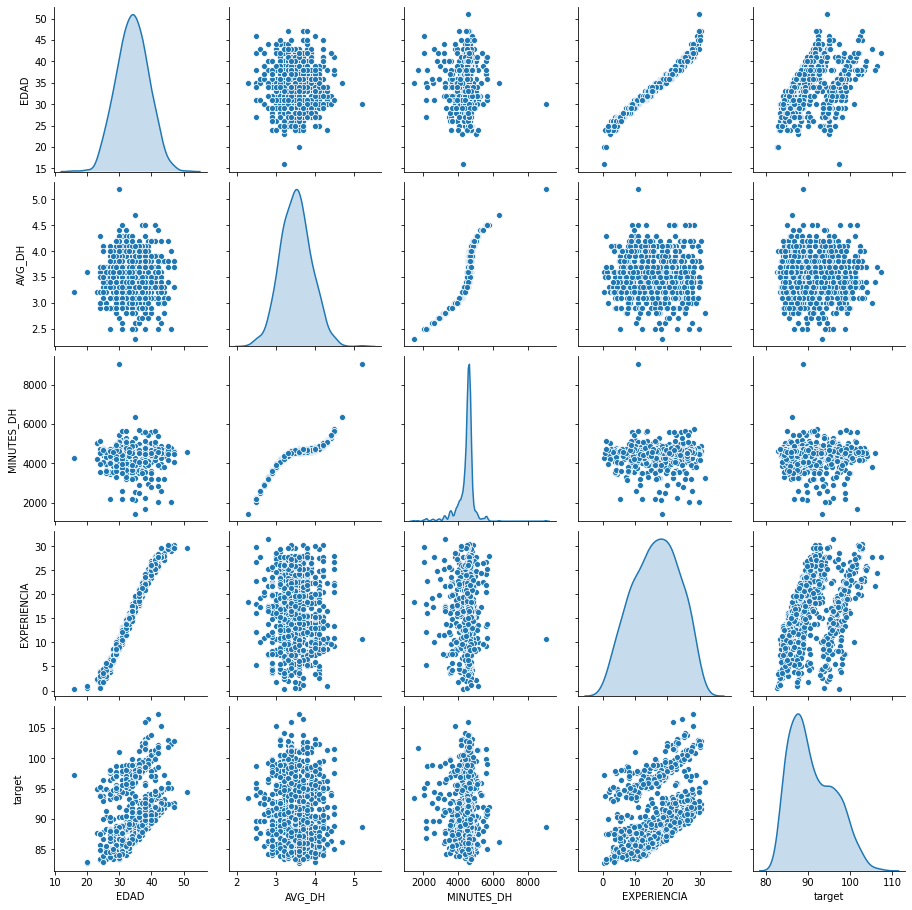

In [99]:
import seaborn as sns
%matplotlib inline

sns.pairplot(features_to_be_scored, diag_kind="kde")